1.このSprintについて

Sprintの目的
公開されている実装を動かす際のノウハウを得る
論文で読んだ手法を動かしてみる

どのように学ぶか
論文で読んだ手法の公開されている実装を実際に動かしていきます。



2.Faster R-CNN

Faster R-CNN[1]の実装を動かします。


[1]Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99


https://arxiv.org/pdf/1506.01497.pdf


以下のものを使用してください。Kerasを使用した実装です。


duckrabbits/ObjectDetection at master

Faster R-CNN

ネットワーク概要

ネットワークを大別すると、backend部、RPN部、head部に分かれます。
backend部は、入力画像の特徴を抽出する役割を担います。論文中では VGGとResNetを採用しています。
RPN部は「物体らしき領域候補」が抽出されます。
head部は「物体らしい」と判定された領域について、RoIプーリングを利用して物体のクラスの確率と領域位置を推定します。

RPN(Region Proposal Network)の導入

Fast R-CNN のネットワーク全体のボトルネックは、Selective Search を利用した領域候補の生成部分でした。
Faster R-CNN では、ROI(region of interest)の生成のために、Selective Searchを RPN(Region Proposal Network) と言われる小さな畳み込みネットワークに入れ替えました。RPNへ渡す特徴マップの生成前に一度だけCNNを実行します。
物体候補領域の高精度化を実現しつつ、真のend-to-end学習を実現しています。


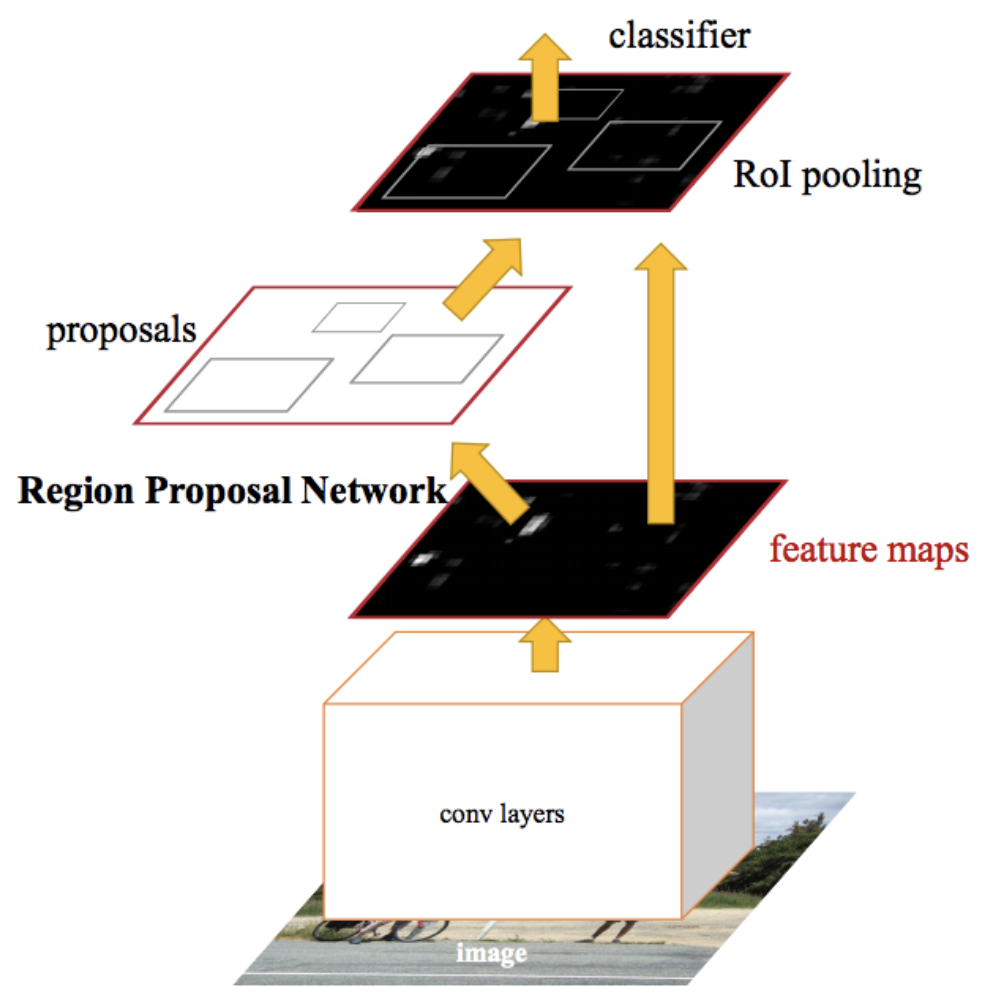

RoIプーリング

RoIプーリングの詳細
RoIプーリングは実際に何をするのかを見ていきます。
入力リストからすべての関心領域について、それに対応する入力特徴マップのセクションを取り、それを予め定義されたサイズ（例えば、7×7）にスケールします。スケーリングは次の方法で行います。

領域候補を同じサイズのセクションに分割します（その数は出力の次元と同じ）
各セクションで最大値を見つける
これらの最大値を出力バッファにコピーする

【問題1】学習と推定
READMEを参考に上記実装を動かしてください。

In [ ]:
#実行後に出たパス：path to config file : ./save/train_20210828-160407_config.pickle

【問題2】コードリーディング
上記実装のコードリーディングを行ってください。


まず、Faster R-CNN[1]において重要だと考えた部分を列挙してください。そして、それに対応するコードを見つけてください。


（例）


RPNを実現しているコードはどこか

RoIプーリングを実現しているコードはどこか


フレームワークには畳み込み層など一般的なものはクラスが用意されていますが、RoIプーリングなど特定の手法限定のものは用意されていません。オリジナルのレイヤーを作成することが可能であり、Kerasであれば以下のページに情報がまとまっています。


オリジナルのKerasレイヤーを作成する - Keras Documentation


《参考》


KerasではVGG16のクラスが用意されているため、簡単に利用ができます。include_top=Falseの引数を与えることで、出力のための全結合層部分が除かれます。weights='imagenet'でImageNetを利用した学習済みモデルも手に入り、転移学習 が行えます。weights='None'とすればランダムな初期化となります。


Applications - Keras Documentation



コードリーディング
【RPNを実現しているコードはどこか】
⇒model>resnet.pyに
def rpn(base_layers,num_anchors):
として定義されている。

def rpn(base_layers,num_anchors):
 
    x = Convolution2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
 
    x_class = Convolution2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Convolution2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
 
    return [x_class, x_regr, base_layers]

（処理内容は、Region Propsal Network(RPN)はCNNの特徴マップ（つまりResnet等のCNN層出力）を入力。

ある領域が物体か背景か(objectness)およびアンカーの位置の補正データ(corrdinates)を出力する。objectnessは0-1の値で1に近いほど物体である確証が高い。corrdinatesはBoundingBoxの四角の座標について補正する量を出力する。）

【RoIプーリングを実現しているコードはどこか】
 ⇒model>RoiPoolingConv.pyに
class RoiPoolingConv(Layer):
が定義されており、

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(1, rows, cols, channels)` if dim_ordering='tf'.
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):
 
        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'
 
        self.pool_size = pool_size
        self.num_rois = num_rois
 
        super(RoiPoolingConv, self).__init__(**kwargs)
 
    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[0][3]
 
    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'th':
            return None, self.num_rois, self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels
 
    def call(self, x, mask=None):
 
        assert(len(x) == 2)
 
        img = x[0]
        rois = x[1]
 
        input_shape = K.shape(img)
 
        outputs = []
 
        for roi_idx in range(self.num_rois):
 
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
 
            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)
 
            num_pool_regions = self.pool_size
 
            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times
 
            if self.dim_ordering == 'th':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length
 
                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')
 
                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)
 
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
 
                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)
 
            elif self.dim_ordering == 'tf':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')
 
                rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)
 
        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
 
        if self.dim_ordering == 'th':
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))
 
        return final_output

        
（RoI Pooling処理内容：region proposalにあたる部分領域をうまく「固定サイズのfeature map」として抽出する）


3.YOLOv3

シンプソンズのデータセットをFaster R-CNN以外の手法で学習・推定を行います。YOLOv3[2]のKeras実装を使います。


qqwweee/keras-yolo3: A Keras implementation of YOLOv3 (Tensorflow backend)


[2]Jeseph Redmon, Ali Farhadi. YOLOv3: An Incremental Improvement


https://pjreddie.com/media/files/papers/YOLOv3.pdf



【問題3】学習済みの重みによる推定
学習済みの重みを使い推定を行う方法がREADME.mdのQuick Startの項に記載されています。


まずはこの通りにして各自何かしらの画像や動画に対して検出を行ってください。


出力結果を課題の一部として提出してください。




In [ ]:
# Loading weights from yolov3.weights...Done!
# data/dog.jpg: Predicted in 19.198002 seconds.
# bicycle: 99%
# truck: 92%
# dog: 100%

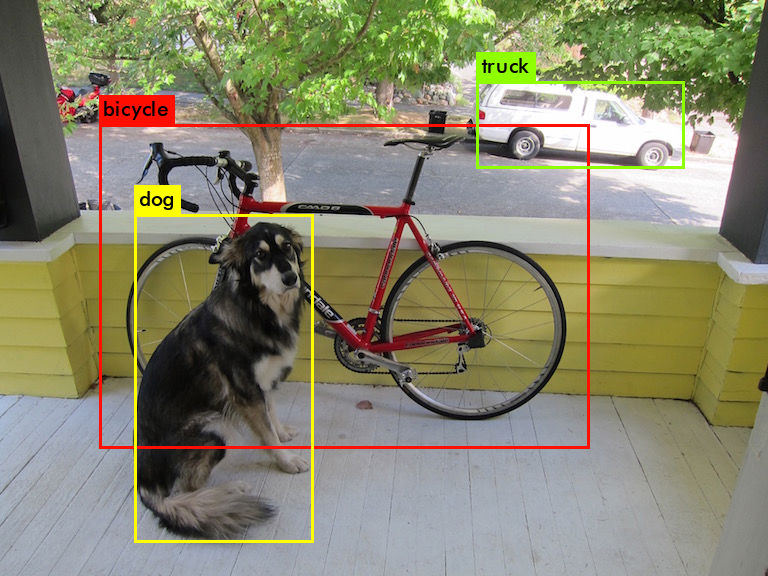![predictions.jpg]()

【問題4】学習のためのファイルを作成
新しいデータ（シンプソンズデータセット）を学習します。README.mdのTrainingの項を読み、シンプソンズデータセットを学習するために必要なファイルを作成してください。


アノテーションファイルの形式が問題1の実装とは異なるため変換する必要があります。





In [16]:
# テキストファイルを読み込み
import pandas as pd
dataset = pd.read_csv("/content/drive/MyDrive/DIC/annotation.csv")
dataset

,image_file_path,x_min,y_min,x_max,y_max,labels
0,./characters/abraham_grampa_simpson/pic_0000.jpg,57,72,52,72,abraham_grampa_simpson
1,./characters/abraham_grampa_simpson/pic_0001.jpg,80,31,337,354,abraham_grampa_simpson
2,./characters/abraham_grampa_simpson/pic_0002.jpg,128,48,285,407,abraham_grampa_simpson
3,./characters/abraham_grampa_simpson/pic_0003.jpg,72,126,158,275,abraham_grampa_simpson
4,./characters/abraham_grampa_simpson/pic_0004.jpg,123,61,294,416,abraham_grampa_simpson
...,...,...,...,...,...,...
6747,./characters/sideshow_bob/pic_0721.jpg,32,89,225,323,sideshow_bob
6748,./characters/sideshow_bob/pic_0779.jpg,110,2,503,392,sideshow_bob
6749,./characters/sideshow_bob/pic_0609.jpg,198,3,525,346,sideshow_bob
6750,./characters/sideshow_bob/pic_0427.jpg,103,75,240,253,sideshow_bob


In [19]:
from sklearn.preprocessing import LabelEncoder
#LabelEncoderのインスタンスを生成
le = LabelEncoder()
#ラベルを覚えさせる
labels = ['abraham_grampa_simpson', 'bart_simpson', 'chief_wiggum', 'marge_simpson', 'nelson_muntz', 'sideshow_bob', 'ned_flanders', 'lisa_simpson', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'principal_skinner', 'comic_book_guy', 'kent_brockman', 'krusty_the_clown', 'edna_krabappel', 'milhouse_van_houten', 'moe_szyslak', 'homer_simpson']
le = le.fit(dataset['labels'])
#ラベルを整数に変換
dataset['labels'] = le.transform(dataset['labels'])
dataset
dataset.to_csv('/content/drive/MyDrive/DIC/annotation.csv')
dataset.to_csv('/content/drive/MyDrive/DIC/annotation.csv', mode='w', header=False)

【問題5】学習が行えることの確認
問題4で作成したファイルを使用して学習してください。実行環境で学習に時間がかかる場合は、学習が行えることを確認するのみで終えて構いません。


In [ ]:
#ターミナルを使用して学習を実行しました。
